In [6]:
# All imports here
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
from datetime import datetime
import matplotlib.pyplot as plt

In [7]:
BATCH_SIZE = 16
SEQUENCE_LENGTH = 64

In [8]:
# Path to the input data directory
input_data_dir = "/content/drive/MyDrive/NeuralNets/Project/data/"
char_to_idx_fname = "char_to_index.json"

train_data_path = input_data_dir + "train.npy"
label_data_path = input_data_dir + "labels.npy"
trained_model_weight_path = input_data_dir + "trained_lstm.h5"

In [9]:
char_to_index = json.load(open(input_data_dir + char_to_idx_fname))
index_to_char = { i: ch for ch, i in char_to_index.items() }
VOCAB_SIZE = len(char_to_index)
print("Char to index mapping size: ", VOCAB_SIZE)

Char to index mapping size:  93


In [10]:
# Get the data and labels from files
data = np.load(train_data_path)
labels = np.load(label_data_path)
print(data.shape, labels.shape)

(441, 16, 64) (441, 16, 64, 93)


In [11]:
# Build LSTM models
def build_lstm(batch_size, seq_length, vocab_size):
  lstm = Sequential()
  lstm.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_length)))
  lstm.add(LSTM(256, return_sequences=True, stateful=True))
  lstm.add(Dropout(0.2))
  lstm.add(LSTM(256, return_sequences=True, stateful=True))
  lstm.add(Dropout(0.2))
  lstm.add(LSTM(256, return_sequences=True, stateful=True))
  lstm.add(Dropout(0.2))
  lstm.add(TimeDistributed(Dense(vocab_size))) 
  lstm.add(Activation("softmax"))

  lstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  lstm.summary()
  return lstm

def build_lstm_predictor(vocab_size):
  lstm = Sequential()
  lstm.add(Embedding(vocab_size, 512, batch_input_shape=(1, 1)))
  lstm.add(LSTM(256, return_sequences=True, stateful=True))
  lstm.add(Dropout(0.2))
  lstm.add(LSTM(256, return_sequences=True, stateful=True))
  lstm.add(Dropout(0.2))
  lstm.add(LSTM(256, return_sequences=False, stateful=True))
  lstm.add(Dropout(0.2))
  lstm.add(Dense(vocab_size, activation="softmax"))
  return lstm

In [12]:
def plot_util(values, xlabel, ylabel, title):
  plt.plot(range(len(values)), values)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

In [13]:
lstm_model = build_lstm(BATCH_SIZE, SEQUENCE_LENGTH, VOCAB_SIZE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (16, 64, 512)             47616     
                                                                 
 lstm (LSTM)                 (16, 64, 256)             787456    
                                                                 
 dropout (Dropout)           (16, 64, 256)             0         
                                                                 
 lstm_1 (LSTM)               (16, 64, 256)             525312    
                                                                 
 dropout_1 (Dropout)         (16, 64, 256)             0         
                                                                 
 lstm_2 (LSTM)               (16, 64, 256)             525312    
                                                                 
 dropout_2 (Dropout)         (16, 64, 256)             0

In [14]:
# Helper for Train the model
def train_model(epochs, data, labels, model):
  avg_loss, avg_accuracy = [], []
  for epoch in range(epochs):

    losses, metrics = [], []
    start = datetime.now()

    # Train on all the batches for a single epoch
    for idx, X in enumerate(data):
      cur_loss, cur_acc = model.train_on_batch(X, labels[idx])
      losses.append(cur_loss)
      metrics.append(cur_acc)
    
    # Average loss and accuracy per epoch
    print(f"Epoch {epoch} : Average loss {np.mean(losses)}, Average accuracy {np.mean(metrics)}")
    avg_loss.append(np.mean(losses))
    avg_accuracy.append(np.mean(metrics))

    if (epoch+1)%10==0:
      print(f"Completed epochs : {epoch+1}")
    
  total_time_taken = datetime.now() - start
  
  return avg_loss, avg_accuracy, total_time_taken

In [15]:
losses, metrics, total_time_taken = train_model(100, data, labels, lstm_model)

Epoch 0 : Average loss 2.2722832999802502, Average accuracy 0.39061614229024944
Epoch 1 : Average loss 1.4464808572717265, Average accuracy 0.5731912556689343
Epoch 2 : Average loss 1.2468474370822344, Average accuracy 0.6107545882936508
Epoch 3 : Average loss 1.1603967396039812, Average accuracy 0.6285320117630385
Epoch 4 : Average loss 1.0965178342633237, Average accuracy 0.6476757369614512
Epoch 5 : Average loss 1.0417018178639228, Average accuracy 0.665867258361678
Epoch 6 : Average loss 0.997495432559595, Average accuracy 0.6803850446428571
Epoch 7 : Average loss 0.9588822334531754, Average accuracy 0.6917694160997733
Epoch 8 : Average loss 0.9226305215807459, Average accuracy 0.7039952699829932
Epoch 9 : Average loss 0.8912874323710833, Average accuracy 0.7134132298752834
Completed epochs : 10
Epoch 10 : Average loss 0.8650377023787725, Average accuracy 0.7218369118480725
Epoch 11 : Average loss 0.8424270916687928, Average accuracy 0.728453621031746
Epoch 12 : Average loss 0.8213

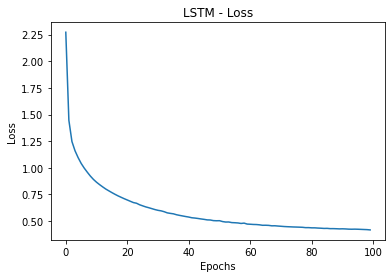

In [16]:
plot_util(losses, 'Epochs', 'Loss', 'LSTM - Loss')

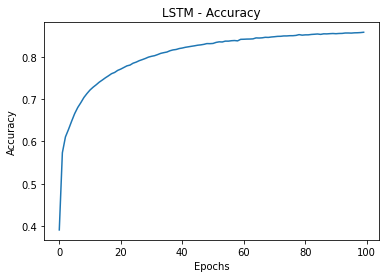

In [17]:
plot_util(metrics, 'Epochs', 'Accuracy', 'LSTM - Accuracy')

In [18]:
print(f'The total time taken to train the LSTM model is {total_time_taken}')

The total time taken to train the LSTM model is 0:00:11.018767


In [19]:
# save the model weights
lstm_model.save(trained_model_weight_path)

In [20]:
# Generate music
def generate_music(length, model):

  sampled = []

  for i in range(length):
      batch = np.zeros((1, 1))

      if len(sampled)>0:
        batch[0, 0] = sampled[-1]
      else:
        batch[0, 0] = np.random.randint(VOCAB_SIZE)
      result = model.predict_on_batch(batch).ravel()
      sample = np.random.choice(range(VOCAB_SIZE), p=result)
      sampled.append(sample)

  return ''.join(index_to_char[c] for c in sampled)

In [21]:
# Build the predictor
predictor = build_lstm_predictor(VOCAB_SIZE)
predictor.load_weights(trained_model_weight_path)

In [22]:
output1 = generate_music(1024, predictor)

In [23]:
output2 = generate_music(1024, predictor)

In [24]:
output3 = generate_music(1024, predictor)

In [25]:
print(output1)

GP/g"B/2d/2g/2f/2|\
"C/e"e3/2d/2 c/2d/2e/2c/2|
"G"d/2B/2c/2B/2 "D"A/2c/2B/2A/2|"G"G(3B/2d/2e/2 "Em"d/2c/2B/2d/2|\
"Am"cA "D7"Ad/2c/2|
"G"Bd/2c/2 BA|"G"GB/2G/2 dd/2c/2|"G"Bd "C"c/2A/2B/2c/2|\
"G"d/2e/2d/2c/2 BD| [1"A7"GB/2G/2 "D7"G/2A/2B/2c/2|"G"d2 d4||[2"G"GB G||


X: 2
T:Western Castle
% Nottingham Music Database
S:Bob McQuillen Jan 1976, via Phil Rowe
M:6/8
K:Em
"Am"EAB c2B|"Am"cBA e2d|"Am"eAA "D7"A2G|E2E G2F|
"G"G3 -"C7"GBd|"C"ede g2e|"G"dBG GAB|"Am"A3 -A2::
c|"Am"ede "D"fed|"Am"eAA eAA|"G"geg g2g|"Am"edc "E7"Bcd|
"Am"eeA eaa|"Am"eag e2d|"G"edB "Em"e2f|
"Am"eee e2d|"Am"eAA e2a|"Am"eaa b2a|"Em"geg "B7"fed|"Am"eeA A2:|


X: 17
T:Winstain's Hornpipe
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:D
A|"D"FED FED|FGA AGF|"G"GGB Bcd|"A"ecA Ace|"Em"gfe "D"dcB|
"A"ABc def|"Em"ede "A"a2A|"D"def fed|"A"ead cBA|"Bm"BdB dBc|
"E7"Bce edc|"Bm"Bcd "Em"e2f|"A7"gfe "D"dfe|"D"d3 D::
d|"D"fgf fga|"Em"gfe eab|"D"afd "A7"gfe|"D"fdd d2||


X: 93
T:Charlican Rode
% Nottingham Music Database
S:Bo

In [26]:
print(output2)


M:4/4
L:1/4
K:G
B|"Em"e/2^f/2e/2d/2 "G"Bd|"Am"e/2a/2a/2b/2 "D"ag/2f/2|\
"G"g/2f/2e/2d/2 "C"eg/2f/2|"C"e/2d/2c/2B/2 "D7"A(3A/2B/2c/2|
"G"dG GB|"D"A2 "c"c/2d/2e/2c/2|"Bm"d/2c/2B/2A/2 "Em"G/2F/2G/2A/2|"D"BA "G"G:|


X: 29
T:Montet Arornis
% Nottingham Music Database
S:Jimmy MacKay, via EF
M:6/8
K:D
P:A
A|:"D"DEF "A7"GFE|"D"FAA ABA|"D"dcd "A7"ede|"D"fdf "A7"a2g|
"D"fdd "A/c+"e2c|"E7/g+"e2d "A7"cde|"D"dfa "A7/e"gfe|"D/f+"dfd "G"BsA|"D"def "G"gab|"D"A2f d2A|"G"BAG FAd|
"D"FGA "A"GFG|"D"FAd fed|"Em"cdB "A7"ABc|"D"d3 d2:|


X: 116
T:The Gleariol
% Nottingham Music Database
S:Gured Tom, via PR
M:4/4
L:1/4
K:G
B|"G"G3A|"G"Bd dB|d/2B/2G B,D|"G"DB B=A|"G"B/2c/2d G3/2G/2|"D"FA AF|
"G"GB B2|"G"g/2f/2e/2d/2 "A7"BA/2G/2|"D"FA A|"G"GB dc|B2 ce|
"G"e/2d/2B/2d/2 gd|"G"B/2dB/2 BA/2B/2|"Am"cA Ad|"D"f/2g/2f/2d/2 "D7"ed|
"G"g3/2b/2 "D"af|"G"ge/2g/2 "D"f/2e/2d/2e/2|"D"f/2e/2d/2B/2 "A7"Ad|\
"D"ff/2e/2 d/2c/2B/2A/2|
"G"G/2F/2G/2A/2 B/2c/2d/2B/2|"D"A/2F/2d/2A/2 F/2A/2d/2c/2|\
"D"dd/2A/2 dA/2F/2D/2|
"A"e/2d/2c/2

In [27]:
print(output3)

F/2A/2F/2 D/2F/2A/2F/2|\
"A7"G/2F/2E/2D/2 "D7"D/2G/2F/2A/2|
"G"GG/2G/2 BG/2A/2|B/2c/2d/2B/2 AB|"D"f/2d/2a/2f/2 gf/2g/2|\
"D"a/2f/2a/2f/2 "G"g/2f/2e/2d/2|"A7"c/2A/2B/2c/2 A/2B/2c/2A/2| [1"D"d d d :|[2 d d d "G"de/2c/2||


X: 36
T:The Waterland's Reel
% Nottingham Music Database
S:EF
M:6/8
K:G
P:A
D|"G"G2G GBd|"C"efg "D7"dBA|"G"B3 "D7"G2A|"G"B2G D2D|"C"E3 "D7"E2E|\
"G"D3 -G2:|
P:B
|:A|"C"e2d efg|"C"g2e "D7"ede|"G"dBG GBd|"C"efg "G"dBd|"D7"c2c "G"BAG|
"G"d2B G2B|"Am"A2B "Am"cBA|"Em"BGE D2D|"C"EFG "D7"AFD|"G"G3 -G2:|
f|:"Em"eBB BAB|"Em"e2f gfe|"Em"g2a bge|"G"dBG GAG|
"C"E2e efg|"C"efg "G"dBA|"G"Bcd dcB|"D7"AFD DEF|
"G"G2G G2d|"C"efg "D"f2d|"C"efg "G"dBd|"D7"c2A "G"G2:|


X: 116
T:The Cat Walks
% Nottingham Music Database
S:Chris Dewhurtt
% via PR
M:4/4
L:1/4
K:D
A|"D"d/2A/2F/2A/2 "G"G/2B/2A/2G/2|"D"F/2A/2d/2A/2 FA/2d/2|\
"A7"c/2A/2c/2e/2 f/2g/2e/2c/2|"D"d/2A/2F/2A/2 D/2F/2A/2d/2|\
"D"fA/2f/2 "A7"g/2e/2c/2e/2|
"D"d/2c/2d/2A/2 "G"B/2G/2A/2B/2|"D"A/2F/2A/2d/2 fe/2f/2:|
"Em"g/2f/2g/2f/2 "A7"g/